# Business Intelligence Data Mining Project

## Title : Evaluating Simulated Transaction Data for the Classification and Prediction of Money Laundering Activities

## Group Members:
### Ajay D Nair (h24ajana@du.se)
### Navib Bajracharya (v25navba@du.se)



## Calling all functions needed

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## Data Loading

In [34]:
# reading data
df = pd.read_csv("C:/Users/ajaxc/OneDrive/Documents/python/BI/SAML-D_ajay_navib.csv")
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [35]:
#configure pandas to display all columns
pd.set_option("display.max.columns",None)
# change column names to lowercase
df.columns = df.columns.str.lower()
df.head()

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


## Exploratory Data Analysis

In [36]:
# EDA
print("\n1. DATASET OVERVIEW")
print(f"Dataset shape: {df.shape}")
print(f"Time period: {df['date'].min()} to {df['date'].max()}")


1. DATASET OVERVIEW
Dataset shape: (9504852, 12)
Time period: 2022-10-07 to 2023-08-23


In [37]:
print("\nMissing values:")
missing_info = df.isnull().sum()
print(missing_info[missing_info > 0] if missing_info.sum() > 0 else "No missing values found")


Missing values:
No missing values found


In [38]:
print("\nTarget variable distribution:")
target_dist = df['is_laundering'].value_counts()
print(target_dist)
print(f"Laundering rate: {target_dist[1]/len(df)*100:.2f}%")


Target variable distribution:
is_laundering
0    9494979
1       9873
Name: count, dtype: int64
Laundering rate: 0.10%


## Feature Engineering

In [39]:
# Combine date and time for analysis
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['dayofweek'] = df['datetime'].dt.day_name()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute

# Transaction characteristics
df['is_cross_border'] = (df['sender_bank_location'] != df['receiver_bank_location']).astype(int)
df['is_currency_conversion'] = (df['payment_currency'] != df['received_currency']).astype(int)


# Define a rough exchange rate dictionary (on google prices 26th May 2025)
exchange_rates = {
'UK pounds' : 1.35,
'Indian rupee' : 0.012,
'Albanian lek' : 0.012,
'Swiss franc': 1.22,
'Pakistani rupee': 0.0035,
'Naira':0.00063,
'Yen': 0.0070,
'Euro': 1.14,
'Dirham':0.27,
'Mexican Peso':0.052,
'Turkish lira':0.026,
'US dollar':1.00,
'Moroccan dirham': 0.11 
}

# Map payment currency to exchange rate and compute amount in USD
df['exchange_rate'] = df['payment_currency'].map(exchange_rates)
df['amount_usd'] = df['amount'] * df['exchange_rate']
df['amount_usd'] = df['amount_usd'].round(2)
# Optional: drop intermediate column
# df.drop(columns='exchange_rate', inplace=True)

#define a country AML risk profile dictionary (according to Basel AML index)
risk_score = {'UK':4.14,
'Albania':4.35,
'Nigeria':6.85,
'Japan':4.77,
'Spain':4.29,
'Switzerland':4.46,
'UAE':6.18,
'Italy':4.80,
'France':3.86,
'Pakistan':5.56,
'Mexico':5.44,
'Austria':4.35,
'Germany':4.63,
'Turkey':5.63,
'India':5.49,
'Morocco':4.94,
'USA':4.81,
'Netherlands':4.52}

# mapping risk_scores with sender and receiver bank location
df['sender_country_mlrisk'] = df['sender_bank_location'].map(risk_score)
df['receiver_country_mlrisk'] = df['receiver_bank_location'].map(risk_score)

df.head()


,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type,datetime,dayofweek,year,month,hour,minute,is_cross_border,is_currency_conversion,exchange_rate,amount_usd,sender_country_mlrisk,receiver_country_mlrisk
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022-10-07 10:35:19,Friday,2022,10,10,35,0,0,1.35,1969.85,4.14,4.14
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,2022-10-07 10:35:20,Friday,2022,10,10,35,1,1,1.35,8126.51,4.14,6.18
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,2022-10-07 10:35:20,Friday,2022,10,10,35,0,0,1.35,19343.39,4.14,4.14
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,2022-10-07 10:35:21,Friday,2022,10,10,35,0,0,1.35,16058.25,4.14,4.14
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022-10-07 10:35:21,Friday,2022,10,10,35,0,0,1.35,155.59,4.14,4.14


In [40]:
# Amount-based features (simplified)
    # Log transform for skewed amounts
df['amount_log']=np.log1p(df['amount_usd']).round(2) #log1phandles0valuessafely

#simplebinningforamountcategories
amount_quartiles=df['amount_usd'].quantile([0.25,0.5,0.75])
df['amount_category']=pd.cut(df['amount_usd'],
bins=[0,amount_quartiles[0.25],amount_quartiles[0.5],
amount_quartiles[0.75],float('inf')],
labels=['Low','Medium','High','Very_High'])

#Time-basedpatterns(simplified)
#Businesshoursflag(9aMto5PM)
df['is_business_hours']=((df['hour']>=9)&(df['hour']<=17)).astype(int)

#weekendflag
df['is_weekend']=(df['dayofweek'].isin([5,6])).astype(int)

#accountactivitypatterns(simplifiedfrequencyanalysis)
#Counttransactionspersender(simplefrequency)
sender_counts=df.groupby('sender_account').size()
df['sender_frequency']=df['sender_account'].map(sender_counts)

#Counttransactionsperreceiver
receiver_counts=df.groupby('receiver_account').size()
df['receiver_frequency']=df['receiver_account'].map(receiver_counts)

#highfrequencyflags(simplethreshold-based)
df['is_high_freq_sender']=(df['sender_frequency']>df['sender_frequency'].quantile(0.9)).astype(int)
df['is_high_freq_receiver']=(df['receiver_frequency']>df['receiver_frequency'].quantile(0.9)).astype(int)

df.head()

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type,datetime,dayofweek,year,month,hour,minute,is_cross_border,is_currency_conversion,exchange_rate,amount_usd,sender_country_mlrisk,receiver_country_mlrisk,amount_log,amount_category,is_business_hours,is_weekend,sender_frequency,receiver_frequency,is_high_freq_sender,is_high_freq_receiver
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022-10-07 10:35:19,Friday,2022,10,10,35,0,0,1.35,1969.85,4.14,4.14,7.59,Low,1,0,15,29,0,0
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,2022-10-07 10:35:20,Friday,2022,10,10,35,1,1,1.35,8126.51,4.14,6.18,9.00,High,1,0,495,12,0,0
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,2022-10-07 10:35:20,Friday,2022,10,10,35,0,0,1.35,19343.39,4.14,4.14,9.87,Very_High,1,0,221,21,0,0
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,2022-10-07 10:35:21,Friday,2022,10,10,35,0,0,1.35,16058.25,4.14,4.14,9.68,Very_High,1,0,9,128,0,0
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022-10-07 10:35:21,Friday,2022,10,10,35,0,0,1.35,155.59,4.14,4.14,5.05,Low,1,0,6,119,0,0


## EDA Visualisations:

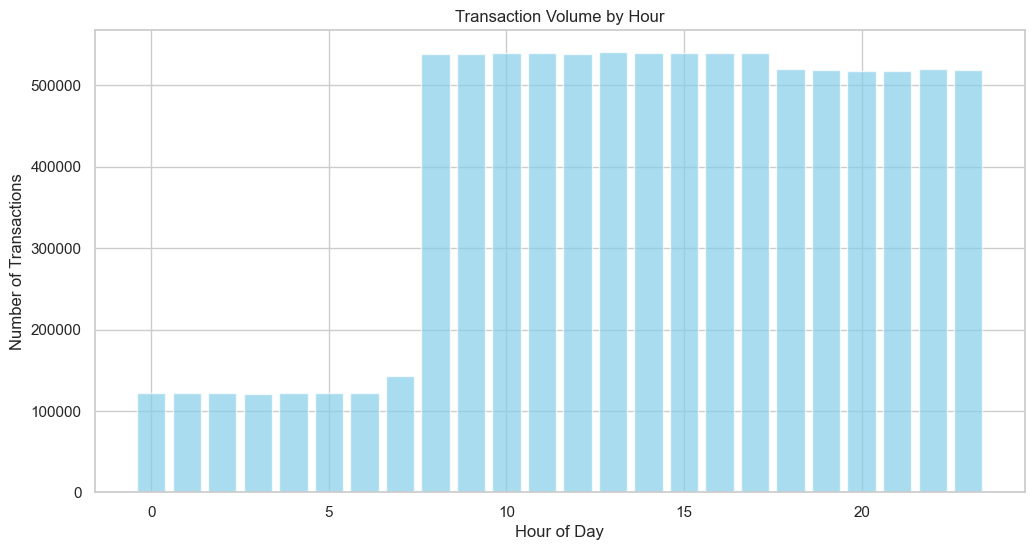

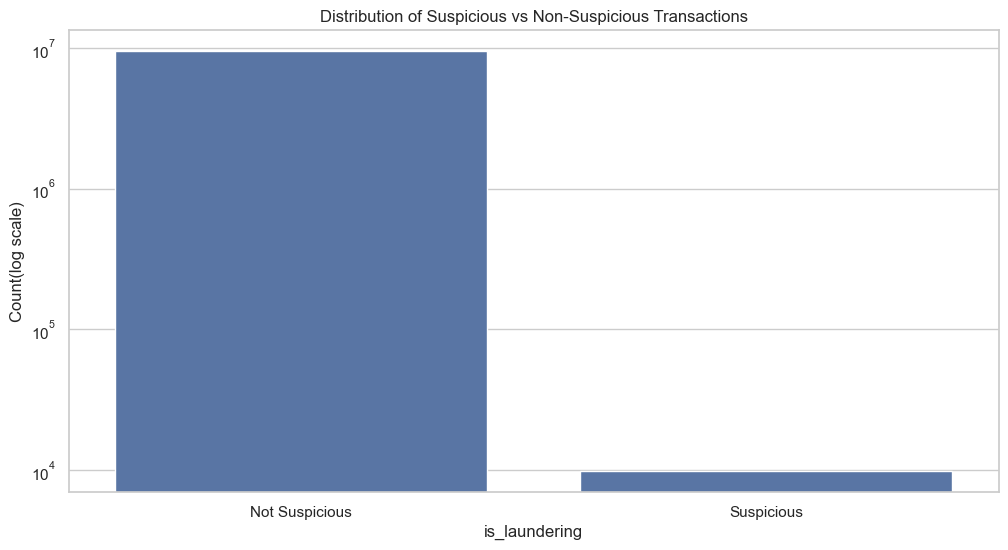

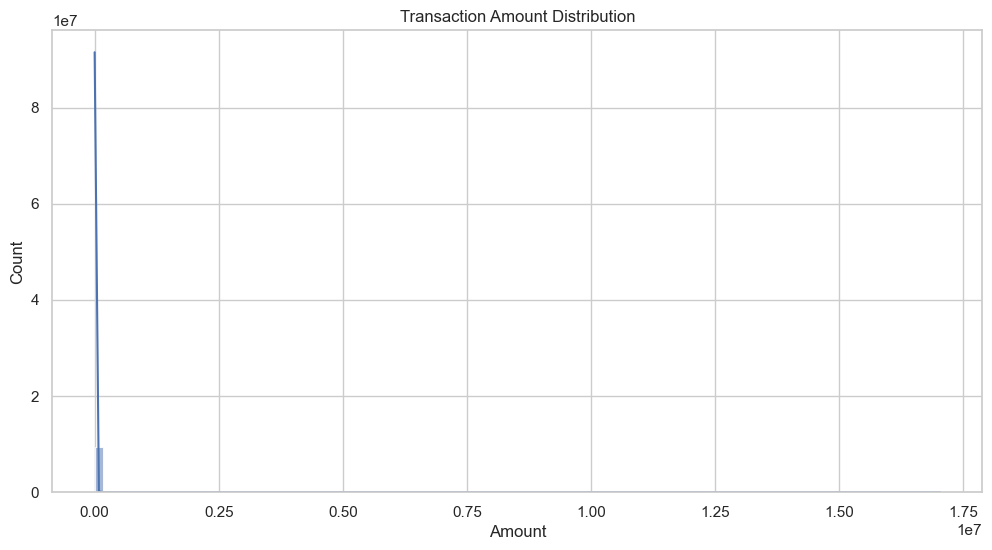

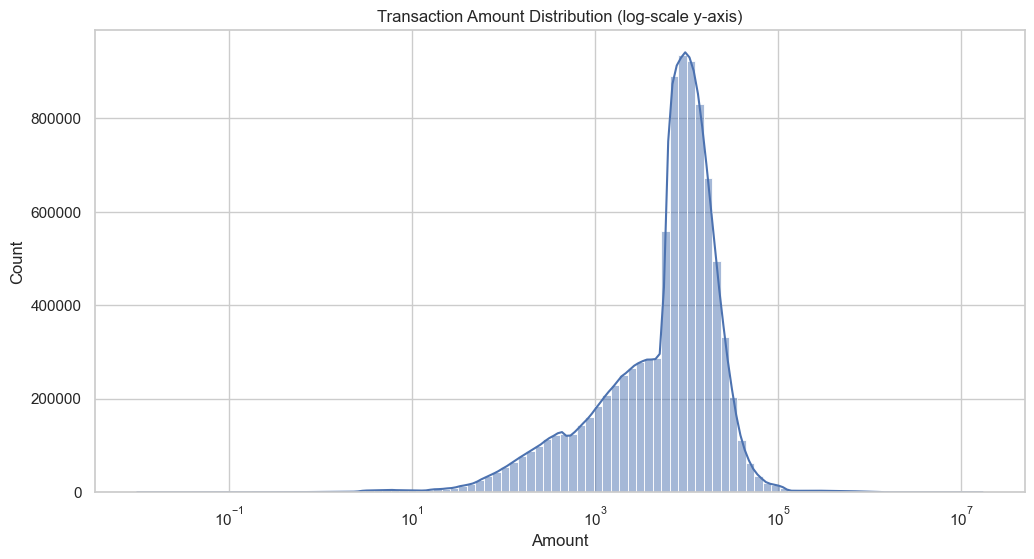

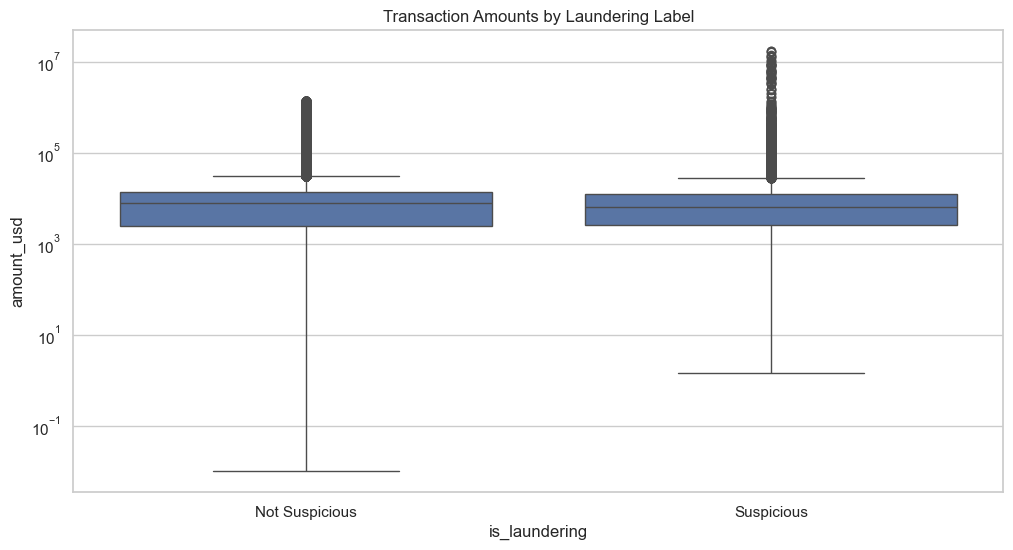

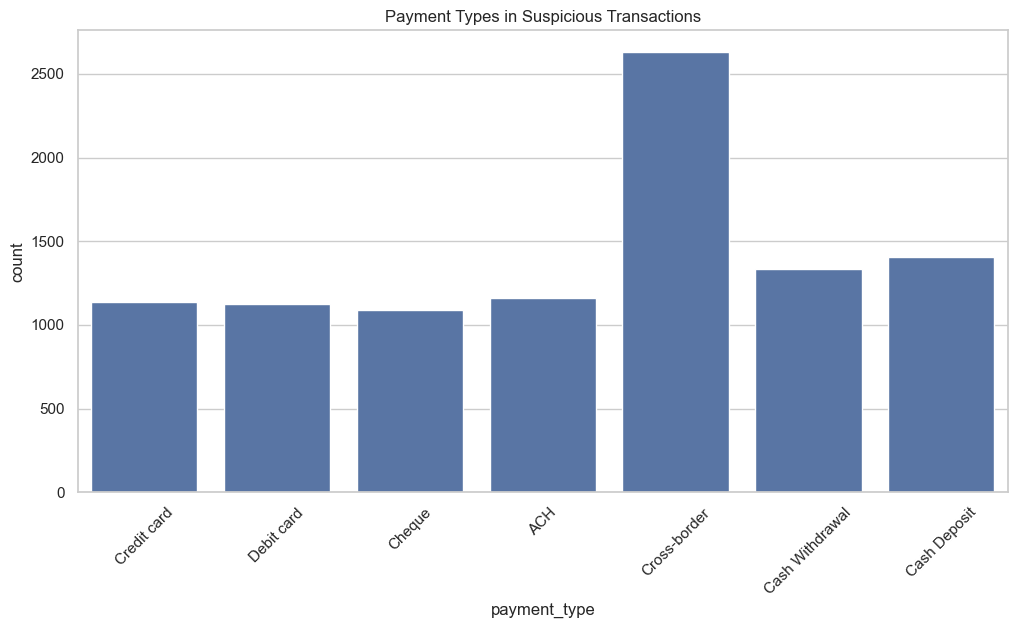

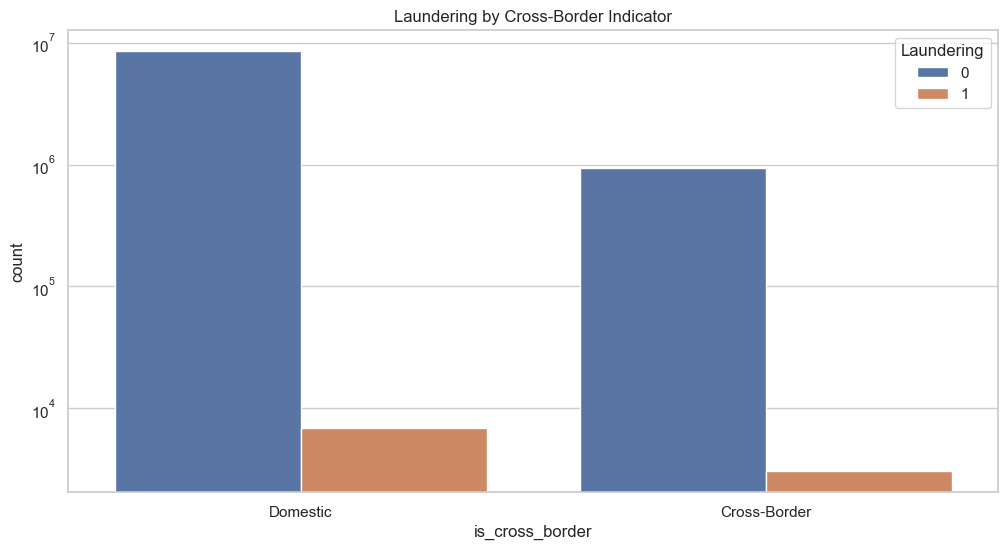

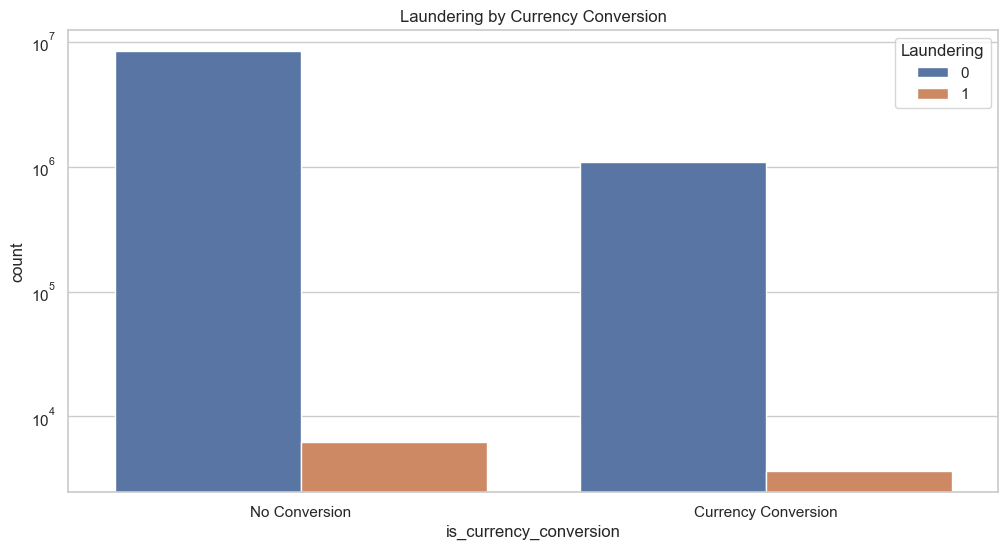

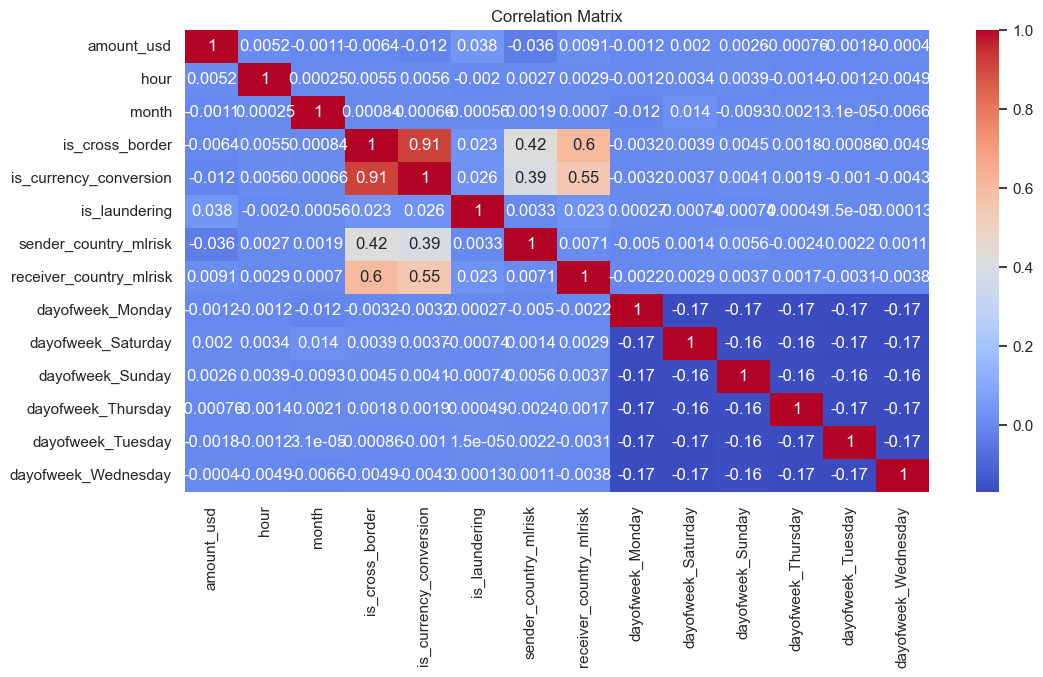

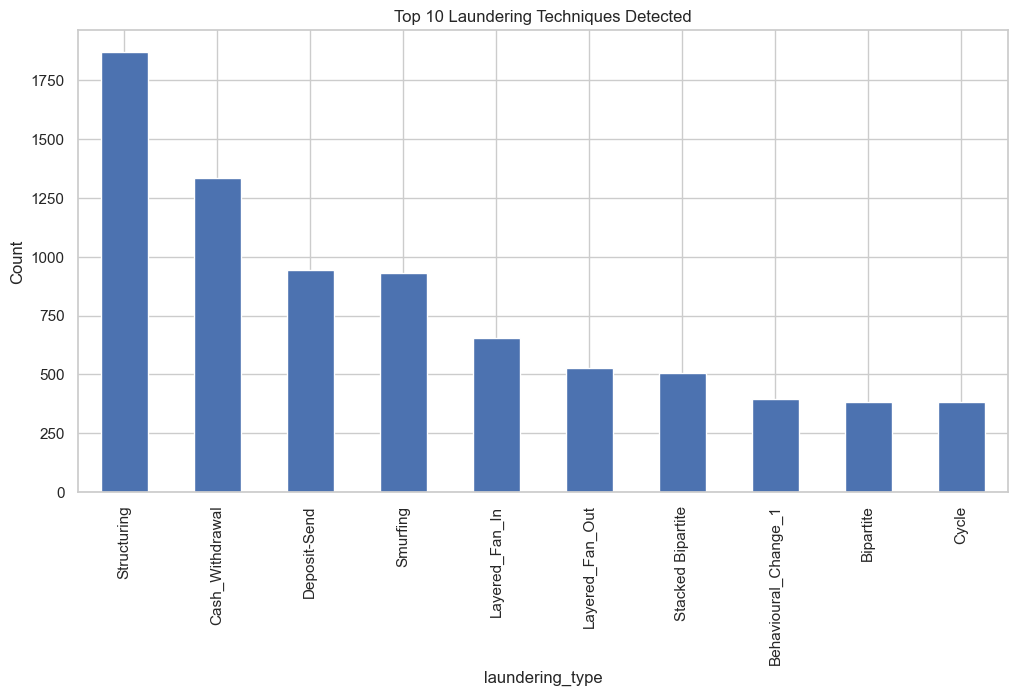

In [41]:
# Setup
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Transaction volume by hour
hourly_counts = df.groupby('hour').size()
plt.bar(hourly_counts.index, hourly_counts.values, alpha=0.7, color='skyblue')
plt.title('Transaction Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.savefig('tn_vol_by_hr.png')
plt.show()

# Check balance of laundering vs non-laundering
sns.countplot(x='is_laundering', data=df)
plt.yscale('log')
plt.title('Distribution of Suspicious vs Non-Suspicious Transactions')
plt.xticks([0, 1], ['Not Suspicious', 'Suspicious'])
plt.ylabel('Count(log scale)')
plt.savefig('imbalance.png', dpi = 300 , bbox_inches = 'tight')
plt.show()

# Amount distribution
sns.histplot(df['amount_usd'], bins=100, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.show()

# Amount distribution after normalisation
sns.histplot(df['amount_usd'], bins=100, log_scale=(True, False), kde = True)
plt.title('Transaction Amount Distribution (log-scale y-axis)')
plt.xlabel('Amount')
plt.show()

# Amount by laundering class
sns.boxplot(x='is_laundering', y='amount_usd', data=df)
plt.yscale('log')
plt.title('Transaction Amounts by Laundering Label')
plt.xticks([0, 1], ['Not Suspicious', 'Suspicious'])
plt.show()

# Suspicious transactions by payment type
plt.xticks(rotation=45)
sns.countplot(data=df[df['is_laundering']==1], x='payment_type', order=df['payment_type'].value_counts().index)
plt.title('Payment Types in Suspicious Transactions')
plt.show()

# Cross-border vs laundering
sns.countplot(x='is_cross_border', hue='is_laundering', data=df)
plt.title('Laundering by Cross-Border Indicator')
plt.yscale('log')
plt.xticks([0, 1], ['Domestic', 'Cross-Border'])
plt.legend(title='Laundering')
plt.show()

# Currency conversion vs laundering
sns.countplot(x='is_currency_conversion', hue='is_laundering', data=df)
plt.title('Laundering by Currency Conversion')
plt.yscale('log')
plt.xticks([0, 1], ['No Conversion', 'Currency Conversion'])
plt.legend(title='Laundering')
plt.show()

# Heatmap of correlations
df_encoded = pd.get_dummies(df[['amount_usd', 'hour', 'dayofweek', 'month', 'is_cross_border',
                                 'is_currency_conversion', 'is_laundering','sender_country_mlrisk',
                                 'receiver_country_mlrisk']], drop_first=True)
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation.png', dpi = 300 , bbox_inches = 'tight')
plt.show()

# Top laundering types
if 'laundering_type' in df.columns:
    laundering_types = df[df['is_laundering']==1]['laundering_type'].value_counts().head(10)
    laundering_types.plot(kind='bar')
    plt.title('Top 10 Laundering Techniques Detected')
    plt.ylabel('Count')
    plt.show()


In [ ]:


# Resample by day
daily_counts = df.resample('D', on='datetime')['is_laundering'].value_counts().unstack().fillna(0)

# Plot
daily_counts.plot(kind='line', figsize=(14, 6))
plt.title("Suspicious vs Non-Suspicious Transactions Over Time")
plt.yscale('log')
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["Non-Suspicious", "Suspicious"])
plt.show()


## Training models and prediction

In [ ]:
# separating the data for undersampling later
not_ldr = df.loc[df['is_laundering']== 0]
ldr = df.loc[df['is_laundering']== 1]

In [ ]:
# Drop IDs
df.drop(columns=['sender_account', 'receiver_account', 'datetime', 'time',
                 'date','laundering_type','amount_usd', 'amount','payment_currency', 'received_currency',
                 'sender_bank_location', 'receiver_bank_location'], inplace=True)
df.head()

In [ ]:
#defining categorical columns
categorical_columns = [ 'payment_type','is_laundering','dayofweek','year','is_cross_border',
                       'is_currency_conversion','amount_category','is_business_hours',
                       'is_weekend','is_high_freq_sender','is_high_freq_receiver', 'month','hour']
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert all categorical columns to numeric (Just hide this section to not use SMOTE)
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



In [ ]:
# Target & features
y = df['is_laundering']
X = df.drop(columns=['is_laundering'])



# Apply SMOTE to balance classes by OVERSAMPLING(Just hide this section to not use SMOTE)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

### Using Imbalanced Data

In [ ]:
# Train-test split without SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- LightGBM ---
lgbm = LGBMClassifier( random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
y_proba = lgbm.predict_proba(X_test)[:, 1]

# Evaluation
print("\nLightGBM Classification Report")
print(classification_report(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,tree_method='hist', enable_categorical=True)
model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nXGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

In [ ]:
# Create confusion matrices
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LightGBM confusion matrix
disp_lgbm = ConfusionMatrixDisplay(cm_lgbm, display_labels=["Not Suspicious", "Suspicious"])
disp_lgbm.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("LightGBM Confusion Matrix")
axes[0].grid(False)

# XGBoost confusion matrix
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=["Not Suspicious", "Suspicious"])
disp_xgb.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].grid(False)

plt.tight_layout()
plt.savefig("no_balancing_results.png", dpi=300, bbox_inches='tight')
plt.show()


### Using SMOTE (Oversampling Data)

In [ ]:


# Train-test split with SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)

# --- LightGBM ---
lgbm = LGBMClassifier( random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
y_proba = lgbm.predict_proba(X_test)[:, 1]

# Evaluation
print("\nLightGBM Classification Report")
print(classification_report(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,tree_method='hist', enable_categorical=True)
model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nXGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

In [ ]:
# Create confusion matrices
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LightGBM confusion matrix
disp_lgbm = ConfusionMatrixDisplay(cm_lgbm, display_labels=["Not Suspicious", "Suspicious"])
disp_lgbm.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("LightGBM Confusion Matrix")
axes[0].grid(False)

# XGBoost confusion matrix
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=["Not Suspicious", "Suspicious"])
disp_xgb.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].grid(False)

plt.tight_layout()
plt.savefig("oversampling_results.png", dpi=300, bbox_inches='tight')
plt.show()


### Using Random Undersampled data

In [ ]:
# statistical measures of the data
not_ldr['amount_log'].describe()

In [ ]:
ldr['amount_log'].describe()

In [ ]:
# Undersampling:
# Building a sample dataset containing similar distribution of normal transactions and fraudulent transactions
# No. of laundering transactions = 9873
not_ldr_sample = not_ldr.sample(n=9873)

# Concatenating two dataframes:
new_df = pd.concat([not_ldr_sample, ldr], axis=0)

new_df.head()

In [ ]:
new_df['is_laundering'].value_counts()

In [ ]:
# Drop IDs
new_df.drop(columns=['sender_account', 'receiver_account', 'datetime', 'time',
                 'date','laundering_type','amount_usd', 'amount','payment_currency', 'received_currency',
                 'sender_bank_location', 'receiver_bank_location'], inplace=True)
new_df.head()

In [ ]:
#defining categorical columns
categorical_columns = [ 'payment_type','is_laundering','dayofweek','year','is_cross_border',
                       'is_currency_conversion','amount_category','is_business_hours',
                       'is_weekend','is_high_freq_sender','is_high_freq_receiver', 'month','hour']
new_df[categorical_columns] = new_df[categorical_columns].astype('category')

# Target & features
y = new_df['is_laundering']
X = new_df.drop(columns=['is_laundering'])

In [ ]:
# Train-test split with Random Undersampled data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- LightGBM ---
lgbm = LGBMClassifier( random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
y_proba = lgbm.predict_proba(X_test)[:, 1]

# Evaluation
print("\nLightGBM Classification Report")
print(classification_report(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,tree_method='hist', enable_categorical=True)
model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nXGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

In [ ]:
# Create confusion matrices
# Create confusion matrices
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LightGBM confusion matrix
disp_lgbm = ConfusionMatrixDisplay(cm_lgbm, display_labels=["Not Suspicious", "Suspicious"])
disp_lgbm.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("LightGBM Confusion Matrix")
axes[0].grid(False)

# XGBoost confusion matrix
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=["Not Suspicious", "Suspicious"])
disp_xgb.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].grid(False)

plt.tight_layout()
plt.savefig("undersampling.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Feature importance plot
importances = pd.Series(lgbm.feature_importances_, index=X_train.columns)
importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Important Features (LightGBM)")
plt.savefig("top15.png", dpi=300, bbox_inches='tight')
plt.show()

## Stastical Validation

In [ ]:
# Undersampling has the smallest datset making it best for crossvalidation 
y = new_df['is_laundering']
X = new_df.drop(columns=['is_laundering'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# RISK SCORING SYSTEM

# Use best model for risk scoring - xgboost
risk_probabilities = model.predict_proba(X_test)[:, 1]

# Define risk categories based on probability thresholds
def assign_risk_level(probability):
    """
    Assign risk levels based on probability thresholds
    - Low Risk: 0.0 - 0.3
    - Medium Risk: 0.3 - 0.7  
    - High Risk: 0.7 - 1.0
    """
    if probability < 0.3:
        return 'Low'
    elif probability < 0.7:
        return 'Medium'
    else:
        return 'High'

# Apply risk scoring
risk_levels = [assign_risk_level(prob) for prob in risk_probabilities]

# Risk distribution analysis
risk_df = pd.DataFrame({
    'Actual': y_test.values,
    'Probability': risk_probabilities,
    'Risk_Level': risk_levels
})

print("Risk Level Distribution:")
risk_dist = pd.crosstab(risk_df['Risk_Level'], risk_df['Actual'], margins=True)
print(risk_dist)

# Calculate precision for each risk level
print("\nRisk Level Performance:")
for risk_level in ['Low', 'Medium', 'High']:
    subset = risk_df[risk_df['Risk_Level'] == risk_level]
    if len(subset) > 0:
        subset['Actual'] = subset['Actual'].astype(float)
        precision = subset['Actual'].mean()
        print(f"{risk_level} Risk: {len(subset)} transactions, {precision:.1%} actual laundering rate")

In [ ]:
# Count the number of transactions in each risk level
risk_counts = risk_df['Risk_Level'].value_counts()

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'orange', 'red'])
plt.title('Risk Level Distribution- Using XGBoost', pad=50)  # Add padding between title and plot
plt.axis('equal')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("risk_profiling.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Feature importance plot
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Important Features (XGBoost)")
plt.savefig("top15_xg.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for laundering class (y_proba = model.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: How Well the Model Ranks Laundering Risk')
plt.legend()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()